## Семинар 8: "Снижение размерности"

ФИО: Елохов Артур Владимирович

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

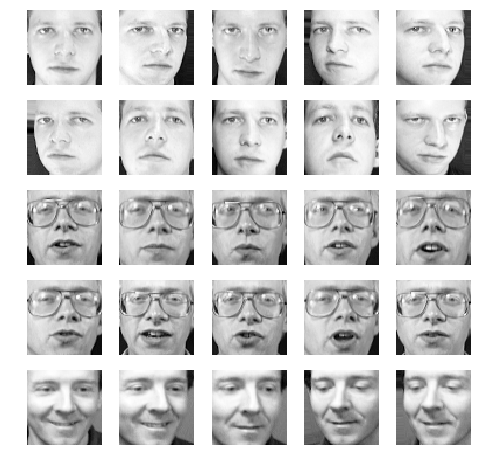

In [3]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [4]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [5]:
model = PCA(n_components = 25)
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

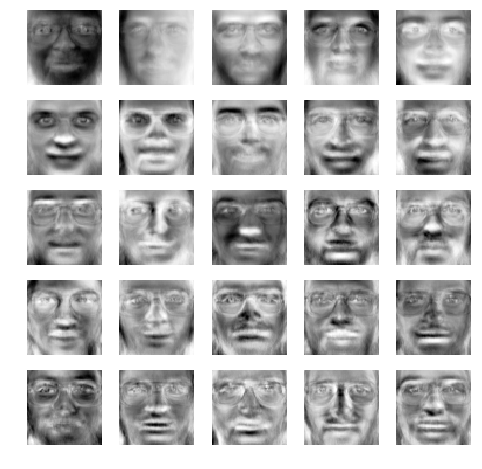

In [6]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(model.components_[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте методы <b>.transform</b> и <b>.inverse_transform</b>

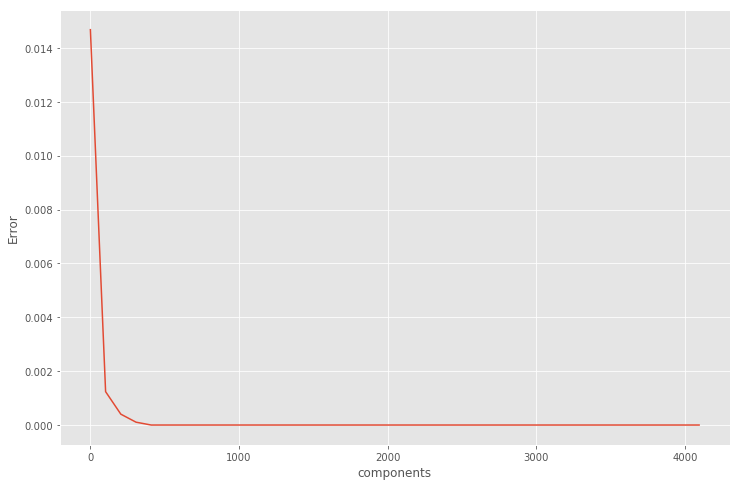

In [7]:
errors = []
for n_components in xrange(1, 64*64, 100):
    model = PCA(n_components)
    model.fit(X)
    X_transformed = model.transform(X)
    reconstructed = model.inverse_transform(X_transformed)
    errors.append(((reconstructed - X)**2).mean())
with plt.style.context('ggplot'):
    plt.figure(figsize=(12,8))
    plt.plot(np.linspace(1, 64*64, 41), errors)
    plt.xlabel("components")
    plt.ylabel("Error")
    plt.show()

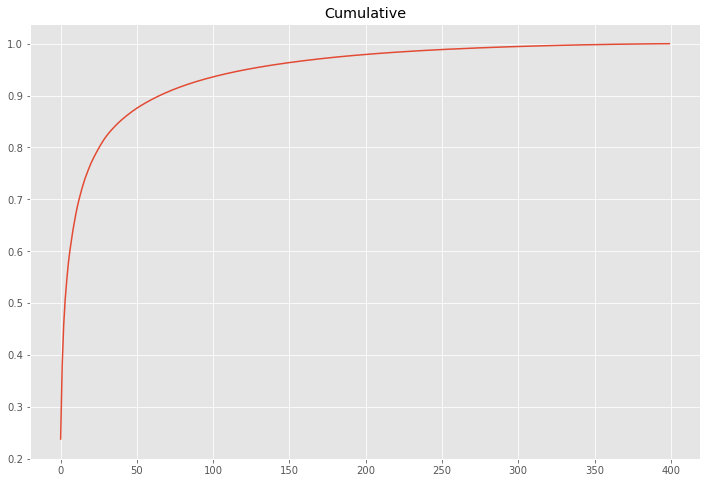

In [8]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(12,8))
    plt.plot(np.cumsum(model.explained_variance_ratio_))
    plt.title("Cumulative")
    plt.show()

In [9]:
model = PCA(500)
X_transformed = model.fit_transform(X)
reconstructed = model.inverse_transform(X_transformed)

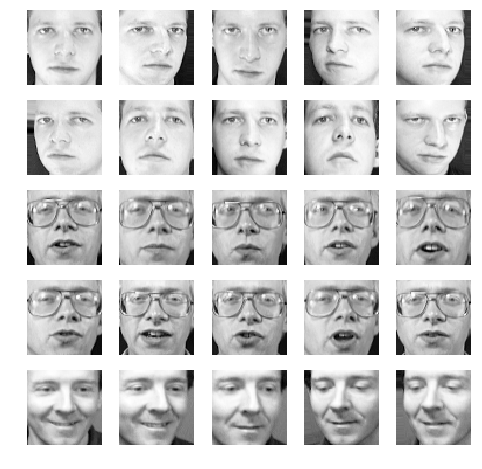

In [10]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(reconstructed[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

500 выглядит неплохо 

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

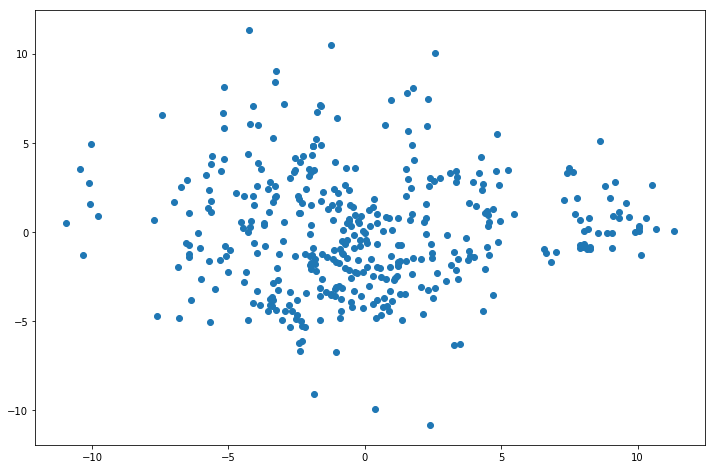

In [11]:
model = PCA(2)
model.fit(X)
embedding = model.transform(X)
plt.figure(figsize=(12,8))
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.show()

In [12]:
#код взят из примеров
def plot_dataset(dataset, x, y, margin=50, frame=2000., imsize=64):
    x1 = np.array((x - x.min()) * (frame / (x.max() - x.min())) + margin, dtype = np.int)
    y1 = np.array((y - y.min()) * (frame / (y.max() - y.min())) + margin, dtype = np.int)
    image = np.zeros((int(x1.max() + margin + imsize), int(y1.max() + margin + imsize))) + 1
    print "Image size is %dx%d" % image.shape
    for k in xrange(dataset.shape[0]):
        image[x1[k]:x1[k]+64, y1[k]:y1[k]+64] = dataset[k].reshape(64, 64)
    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

Image size is 2164x2164


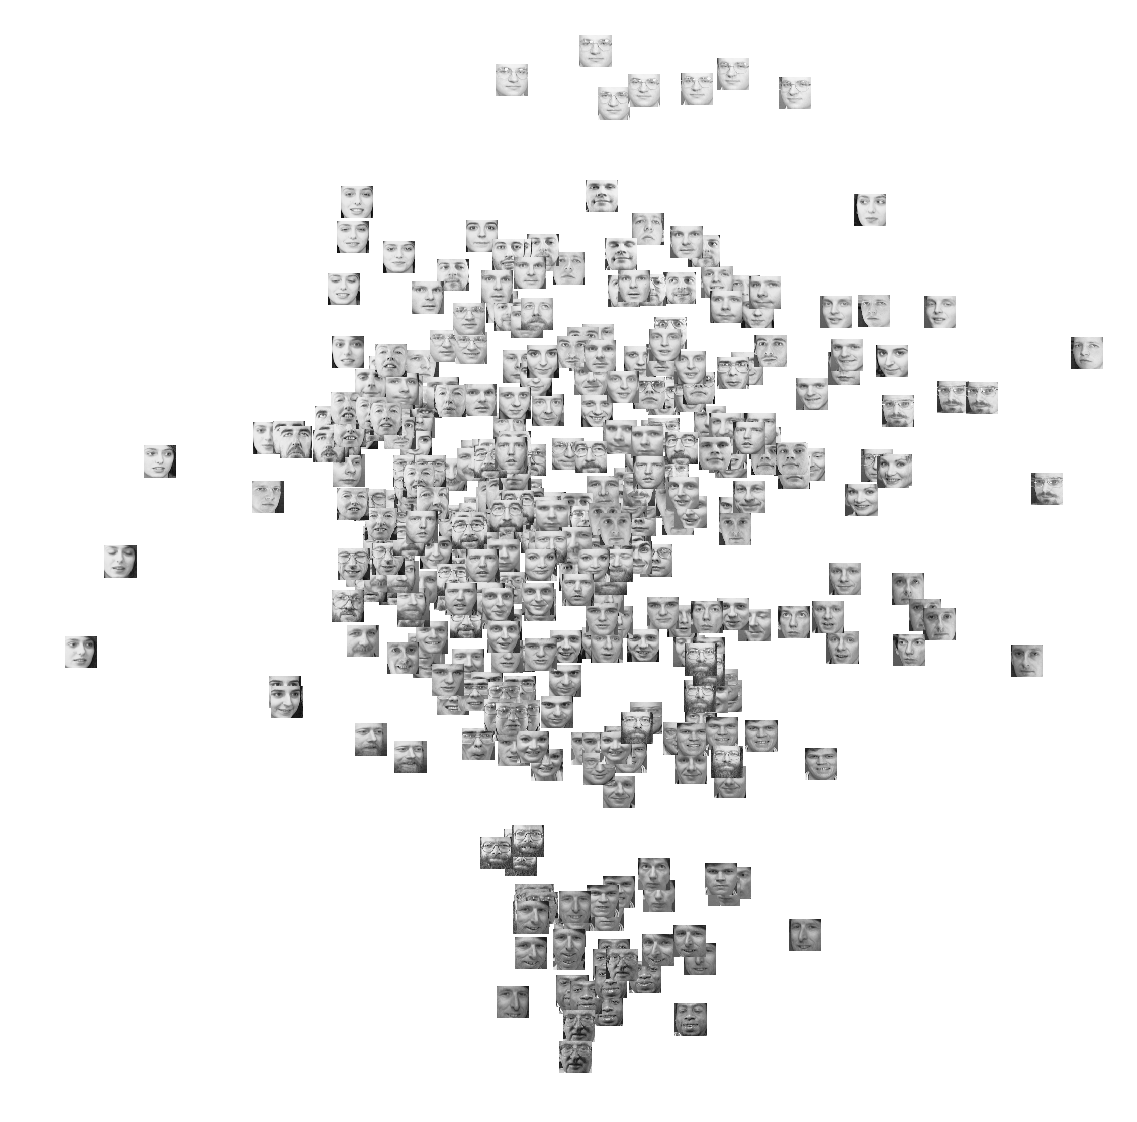

In [13]:
plot_dataset(X, embedding[:, 0], embedding[:, 1])

первая компонента отвечает за освещение. Вторая похожа на положение лица на картинке.

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [14]:
import sys
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim

In [15]:
class FaceDataset(Dataset):
    def __init__(self, X, transform=None):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

In [16]:
data = FaceDataset(X)
loader = DataLoader(data, batch_size=16, shuffle=True, num_workers=4)

In [17]:
def fully_connected(arc, last_nonlinearity=True):
    layers = []
    for i in xrange(len(arc) - 1):
        layers.append(nn.Linear(arc[i], arc[i+1]))
        if(i != len(arc) - 2 or last_nonlinearity):
            layers.append(nn.LeakyReLU())
    return nn.Sequential(*layers)

class AutoEncoder(nn.Module):
    def __init__(self, arc_encoder, arc_decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = fully_connected(arc_encoder)
        self.decoder = fully_connected(arc_decoder)
        
    def encode(self, X):
        return self.encoder(X)
    
    def decode(self, X):
        return self.decoder(X)
    
    def forward(self, X):
        return self.decode(self.encode(X))

In [18]:
def apply_model(model, loader, Epoch, learning_rate):
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    general_loss = []
    for epoch in xrange(Epoch):
        losses = []
        for x in loader:
            x_batch = Variable(x)
            y_batch = Variable(x, requires_grad=False)
            model.zero_grad()
            x_reconstruction = model(x_batch)
            loss_batch = loss(x_reconstruction, y_batch)
            loss_batch.backward()
            optimizer.step()
            losses.append(loss_batch.data[0])
        general_loss.append(np.mean(losses))
        sys.stdout.write('\r {}'.format(np.mean(losses)))
    return general_loss        

In [19]:
model = AutoEncoder([4096, 200, 100], [100, 200, 4096])
Losses = apply_model(model, loader, 200, 0.001)

 0.00255748875439

<i> 2.2 Какое качество восстановления удалось получить?</i>

In [20]:
print "MSE: %f" %Losses[-1]

MSE: 0.002557


<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

In [21]:
model = AutoEncoder([4096, 200, 50], [50, 200, 4096])
Losses = apply_model(model, loader, 200, 0.001)

 0.00290227942169

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

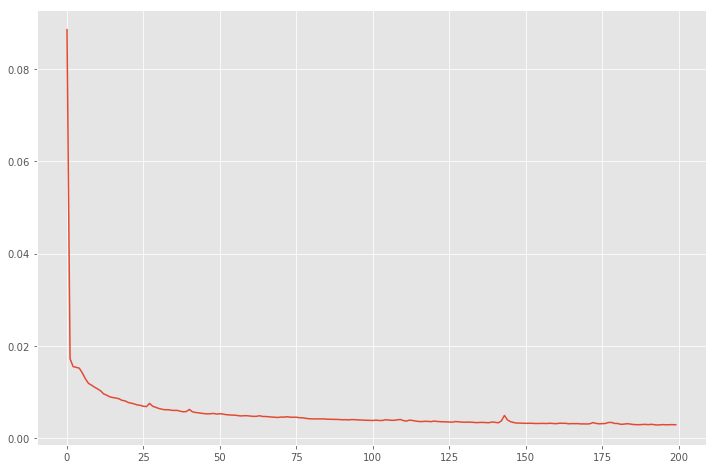

In [22]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(12, 8))
    plt.plot(Losses)
    plt.show()

In [23]:
print "MSE: %f" %Losses[-1]

MSE: 0.002902


<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [24]:
model = AutoEncoder([4096, 200, 2], [2, 200, 4096])
Losses = apply_model(model, loader, 200, 0.001)

 0.0109817515686

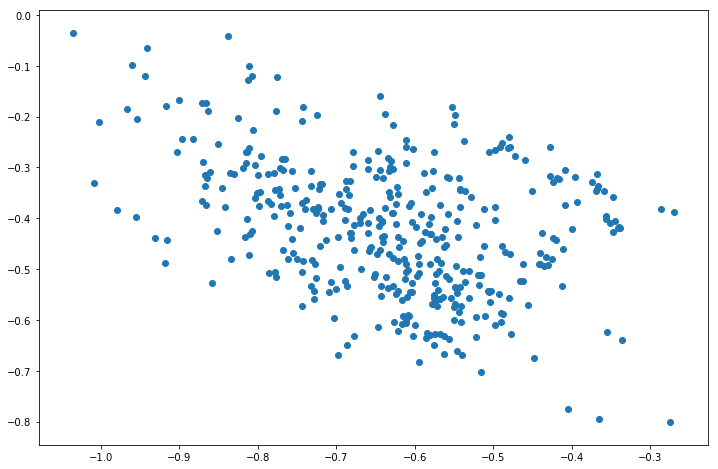

In [25]:
embedding = model.encode(Variable(torch.from_numpy(X))).data.numpy()
plt.figure(figsize=(12,8))
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.show()

Image size is 2164x2164


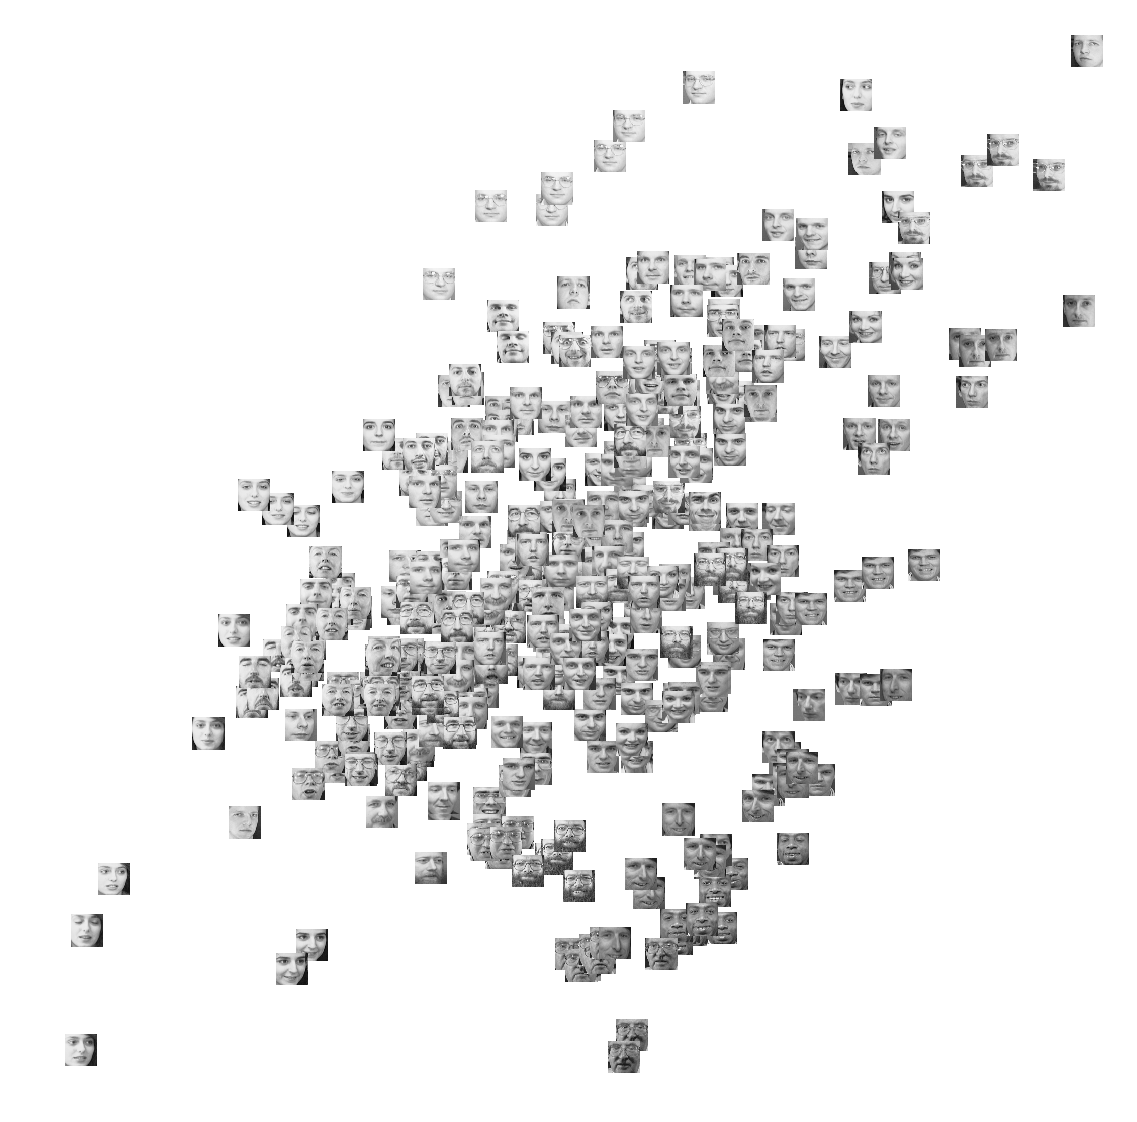

In [26]:
plot_dataset(X, embedding[:, 0], embedding[:, 1])

По вертикали картинки также разделены по яркости освещения.
По горизонтали - по положению лица на картинке: слева, по центру, справа.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: